# 1. Build a convolutional neural network to classify object proposals (N+1 classes)

In [1]:
import json
import os
from sklearn.model_selection import train_test_split
from PIL import Image

# Load splits.json
with open('../Potholes/splits.json', 'r') as f:
    splits = json.load(f)

# Extract train and test splits
train_files = splits['train']
test_files = splits['test']

# Further split the train set into train and validation
train_files, val_files = train_test_split(train_files, test_size=0.2, random_state=42)

In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
# Paths
from Dataset import PotholeDataset
from tqdm import tqdm
img_dir = '../Potholes/annotated-images'
annotations_dir = '../Potholes/labeled_proposals'

# Initialize datasets
train_dataset = PotholeDataset(img_dir, annotations_dir, train_files, transform=transform)
val_dataset = PotholeDataset(img_dir, annotations_dir, val_files, transform=transform)
test_dataset = PotholeDataset(img_dir, annotations_dir, test_files, transform=transform)

Loading annotations: 100%|██████████| 133/133 [00:00<00:00, 791.67it/s]


In [ ]:
from OurDataloader import balanced_loader

train_loader = balanced_loader(train_dataset, batch_size=16)  # DataLoader for training
val_loader = balanced_loader(val_dataset, batch_size=16)    # DataLoader for validation
test_loader = balanced_loader(test_dataset, batch_size=16, shuffle=False, weight_sample=False)    # DataLoader for testing



In [5]:
import torch
from PotholeCNN import PotholeCNN
from TrainLoop import train
# Initialize model, optimizer, and load data
model = PotholeCNN()  # Your model class
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the model
train(model, optimizer, epochs=10, train_loader=train_loader, test_loader=val_loader, device=device)

Training Progress:   1%|          | 102/8893 [00:07<10:07, 14.46it/s]


KeyboardInterrupt: 

In [6]:
import matplotlib.pyplot as plt

def visualize_proposals_with_labels(batch, grid_size=(4, 4)):
    """
    Visualizes a batch of proposals with their labels in a grid.
    
    Args:
        batch (tuple): A batch of (images, labels) from the DataLoader.
        grid_size (tuple): Number of rows and columns in the grid (default: 4x4).
    """
    inputs, labels = batch[0], batch[1]  # Assuming (images, labels)
    inputs, labels = inputs.cpu(), labels.cpu()  # Move to CPU for visualization

    rows, cols = grid_size
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))

    for idx, ax in enumerate(axes.flatten()):
        if idx >= len(inputs):
            ax.axis('off')  # Turn off extra subplots if batch size < grid size
            continue
        
        img = inputs[idx].permute(1, 2, 0).numpy()  # Convert CHW to HWC for visualization
        label = labels[idx].item()

        ax.imshow(img)
        ax.axis('off')
        title = "Pothole" if label == 1 else "Background"
        ax.set_title(title)
    
    plt.tight_layout()
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.30042..1.8379141].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7754089..2.3611329].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.265406..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6475817..2.3410363].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.0822659].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5980392..2.2914162].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1075436..2.64]

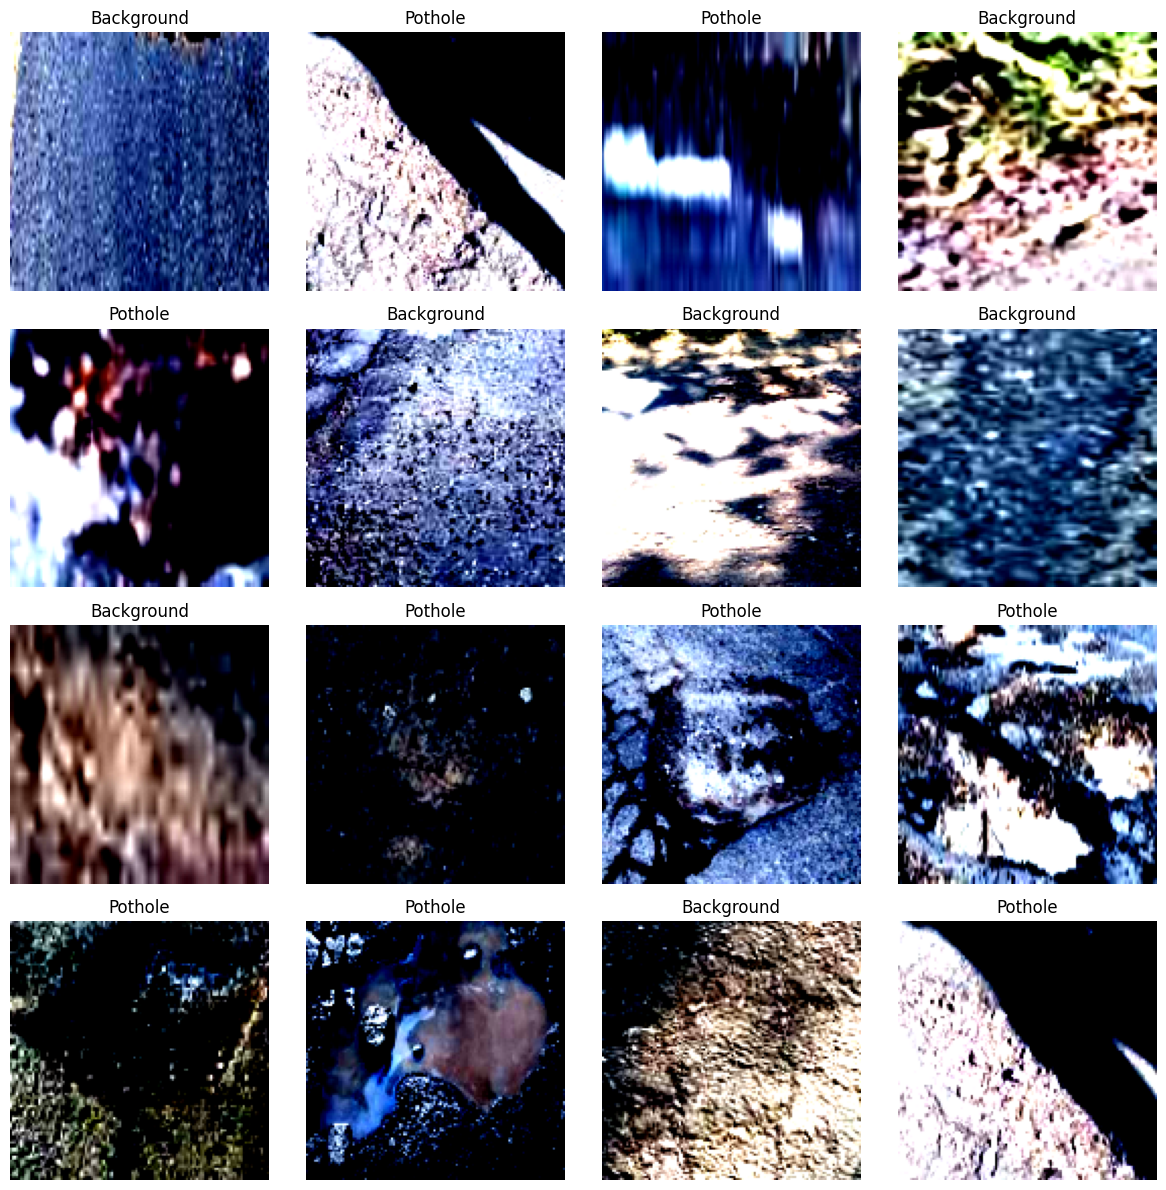

In [7]:
# Get a batch from the DataLoader
batch_no = 10
for i, batch in enumerate(train_loader):
    if i+1 == batch_no:
        batch_vis = batch
        break

# Visualize the proposals with their labels in a 4x4 grid
visualize_proposals_with_labels(batch_vis, grid_size=(4, 4))
